# 적대적 생성 신경망(Generative Adversarial Networks, GAN)

- 2014년, Ian Goodfellow 소개

- VAE와는 다른 방법으로 이미지 잠재 공간을 학습

- 직관적으로 이해하는 방법

  - 가짜 피카소 그림을 그리는 위조범과 이를 판별하는 판매상의 관계

  - 위조품과 진짜 그림을 섞어서 판매상에게 보여주며  
    그림이 진짜인지 가짜인지 판매상은 판별하고 이를 위조범에게 피드백

  - 처음에는 형편없는 그림을 그리다가 점점 피카소의 스타일을 모방하게 되고  
    판매상은 위조품을 구분하는데 점점 더 전문가가 되어감

- GAN의 네트워크

  - 생성자 네트워크(generator network)

    - 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이를 합성된 이미지로 디코딩

  - 판별자 네트워크(discriminator netowrk)

    - 이미지(실제 또는 가짜 이미지)를 입력으로 받아 훈련 세트에서 온 이미지인지 생성자가 만든 이미지인지 판별

- GAN은 최적화의 최솟값이 고정되어 있지 않음

  - 보통의 경사하강법은 **고정된 손실공간**에서 언덕을 내려오는 훈련 방법이지만  
    GAN은 매 단계가 조금씩 전체 공간을 바꾸기 때문에 최적화 과정이 최솟값을 찾는 것이 어려움

  - 두 힘간의 평형점을 찾는 시스템

  - 따라서, 학습과정이 매우 어려움  
    즉, 적절한 파라미터를 찾고 조정해야함
  
  <img src="https://paperswithcode.com/media/methods/gan.jpeg">

  <sub>[이미지 출처] https://paperswithcode.com/method/gan</sub>


## GAN의 구현 (DCGAN)

- CIFAR10 데이터셋 사용

- generator 네트워크는 (latent_dim,) 크기의 벡터를 (32, 32, 3) 크기의 이미지로 매핑

- discriminator 네트워크는 (32, 32, 3) 크기의 이미지가 진짜일 확률을 추정하여 이진값으로 매핑

- 생성자와 판별자를 연결하는 gan 네트워크를 만듬  
  
  - gan(x) = discriminator(generator(x))

- 진짜/가짜 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용하여 판별자를 훈련 (일반적인 이미지 분류 모델 훈련과 동일)

- 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용

  - 매 단계마다 생성자에 의해 디코딩된 이미지를 판별자가 "진짜"로 분류하도록 한다는 방향으로 생성자의 가중치를 이동

  - 판별자를 속이도록 생성자를 훈련한다는 말


## 학습 방법

- 마지막 활성화 함수로 sigmoid 대신 tanh함수 사용

- 균등분포가 아니고 정규 분포(가우시안 분포)를 사용하여 잠재 공간에서 포인트를 샘플링

- 무작위성을 주입

  - 판별자에 드롭아웃을 사용

  - 판별자를 위해 레이블에 랜덤 노이즈를 추가

- 희소한 그래디언트는 GAN 훈련에 방해가 될 수 있음

  - 최대 풀링 대신 스트라이드 합성곱을 사용하여 다운샘플링

  - ReLU 대신 LeakyReLU 사용

- 생성자에서 픽셀 공간을 균일하게 다루지 못하여 생성된 이미지에서 체스판 모양이 종종 나타남.  
  이를 위해 생성자와 판별자에서 스트라이드 Conv2DTranpose나 Conv2D를 사용할 때 스트라이드 크기로 나누어 질 수 있는 커널 크기 사용

  - 커널 크기가 스트라이드의 배수가 아니면 픽셀이 공평하게 합성곱 되지 않음  
    커널 크기를 스트라이드로 나누었을 때 나머지 크기에 해당하는 픽셀이 더 많이 업샘플링에 참여하게 됨


LeakyReLU : https://gooopy.tistory.com/56

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose,Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = Input(shape=(latent_dim,))

x = Dense(128*16*16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16,16,128))(x)

x = Conv2DTranspose(256,4,strides=2,padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels,7,activation='tanh', padding='same')(x)
generator = Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      524544    
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                             

In [4]:
from tensorflow.keras.optimizers import RMSprop
discriminator_input = Input(shape= (height,width,channels))
x = Conv2D(128,3)(discriminator_input)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)

x = Dropout(0.4)(x)

x = Dense(1,activation = 'sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6, 6, 128)         0   

In [6]:
discriminator_optimizer = RMSprop(learning_rate=0.0008,clipvalue=1.0,decay = 1e-8)
discriminator.compile(optimizer = discriminator_optimizer, loss = 'binary_crossentropy')

In [7]:
# 판별자의 가중치가 훈련되지 않도록 설정

discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))

gan = Model(gan_input,gan_output)

gan_optimizer = RMSprop(learning_rate = 0.0004, clipvalue=1.0, decay = 1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [8]:
import os
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image

(x_train,y_train), (_,_) = cifar10.load_data()

# 개구리 이미지 선택(클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터 정규화
x_train = x_train.reshape((x_train.shape[0],) + (height,width,channels)).astype('float32')/255.

iterations = 10000
batch_size = 20
save_dir = './gan_images/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

170508288/170498071 [==============================] - 8s 0us/step


In [9]:
labels = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])
labels += 0.05 *np.random.random(labels.shape)

In [13]:
# 잠재 공간에서 무작위로 포인트를 샘플링
start = 0
for step in range(iterations):
  random_latent_vectors = np.random.normal(size = (batch_size,latent_dim))
  # 랜덤 노이즈를 사용하여 generator 이미지를 생성(가짜 이미지를 디코딩)
  generated_images = generator.predict(random_latent_vectors)

  # 생성된 이미지와 진짜 이미지를 섞음
  stop = start + batch_size 
  real_images = x_train[start:stop]
  combined_images = np.concatenate([generated_images,real_images])

  #진짜와 가짜 이미지를 구분하여 레이블을 합침
  labels = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size, 1))])

  # 레이블에 랜덤 노이즈 추가
  labels += 0.05 * np.random.random(labels.shape)

  #진짜와 가짜가 섞인 이미지와 이에 대응하는 타겟을 사용하여 discriminator를 훈련
  d_loss = discriminator.train_on_batch(combined_images,labels)

  # 잠재 공간에서 무작위로 포인트 샘플링
  random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))

  # 모든 타겟은 진짜로 설정, 판별자가 생성된 이미지를 모두 진짜 이미지라고 예측하도록 생성자의 가중치를 업데이트
  # GAN 안에서 판별자는 동결되기 때문에 생성자만 업데이트, 결국 생성자는 판별자를 속이도록 훈련
  misleading_targets = np.zeros((batch_size,1))
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0
  if step % 10 == 0:
    gan.save_weights('gan.h5')
    print(f'스텝 {step}에서 판별자 손실 : {d_loss}')
    print(f'스텝 {step}에서 생성자 손실 : {a_loss}')

    # 생성된 이미지 저장
    img = image.array_to_img(generated_images[0] * 255., scale=False)
    img.save(os.path.join('real_frog'+str(step)+'.png'))

스텝 0에서 판별자 손실 : 2.8403491973876953
스텝 0에서 생성자 손실 : 0.03758736699819565
스텝 10에서 판별자 손실 : 0.6971452832221985
스텝 10에서 생성자 손실 : 0.7203190922737122
스텝 20에서 판별자 손실 : 0.6831481456756592
스텝 20에서 생성자 손실 : 0.6837975382804871
스텝 30에서 판별자 손실 : 0.6857295632362366
스텝 30에서 생성자 손실 : 0.7778077721595764
스텝 40에서 판별자 손실 : 0.7049816846847534
스텝 40에서 생성자 손실 : 1.3492331504821777
스텝 50에서 판별자 손실 : 1.0194447040557861
스텝 50에서 생성자 손실 : 6.74932336807251
스텝 60에서 판별자 손실 : 0.6469506025314331
스텝 60에서 생성자 손실 : 3.842820644378662
스텝 70에서 판별자 손실 : 0.5997878313064575
스텝 70에서 생성자 손실 : 0.9035553932189941
스텝 80에서 판별자 손실 : 0.7794071435928345
스텝 80에서 생성자 손실 : 0.9287214279174805
스텝 90에서 판별자 손실 : 0.7030878067016602
스텝 90에서 생성자 손실 : 1.4163482189178467
스텝 100에서 판별자 손실 : 0.6937719583511353
스텝 100에서 생성자 손실 : 0.7295355200767517
스텝 110에서 판별자 손실 : 0.6916447877883911
스텝 110에서 생성자 손실 : 0.8264714479446411
스텝 120에서 판별자 손실 : 0.7053617238998413
스텝 120에서 생성자 손실 : 0.8379744291305542
스텝 130에서 판별자 손실 : 0.655068576335907
스텝 130에서 생성자 손실 : 0.786797

(10, 32, 32, 3)


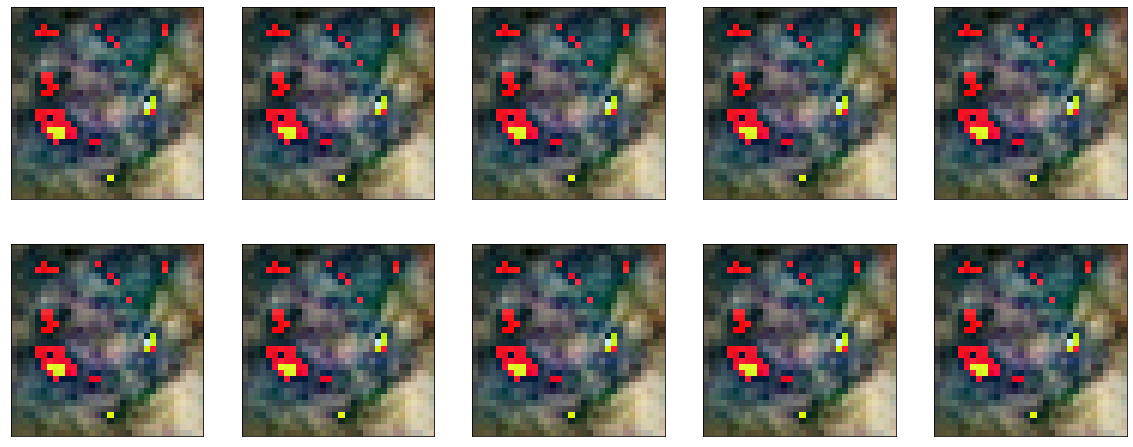

In [14]:
import matplotlib.pyplot as plt
random_latent_vectors = np.random.normal(size = (10,latent_dim))
generated_images = generator.predict(random_latent_vectors)
print(generated_images.shape)

plt.figure(figsize = (20,8))
for i in range(generated_images.shape[0]):
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

plt.show()